In [183]:
%matplotlib inline
import matplotlib.image as mpimg
from torch import nn
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from torchinfo import summary
import torch
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from PIL import Image
from utils import read_all_images, img_crop
from augmentation import augment_data, rot90, rot180, rot270, fliph, flipv, flipvh
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("Goodluck")

device = torch.device(device)

# Dataset loading

In [185]:
IMAGE_SRC_DIR = "training/images/"
IMAGE_GT_DIR = "training/groundtruth/"

IMAGES_SRC = np.asarray(read_all_images(IMAGE_SRC_DIR))
IMAGES_GT = np.asarray(read_all_images(IMAGE_GT_DIR))

IMAGES_SRC.shape

(100, 400, 400, 3)

# Augment data

Testing multiple examples

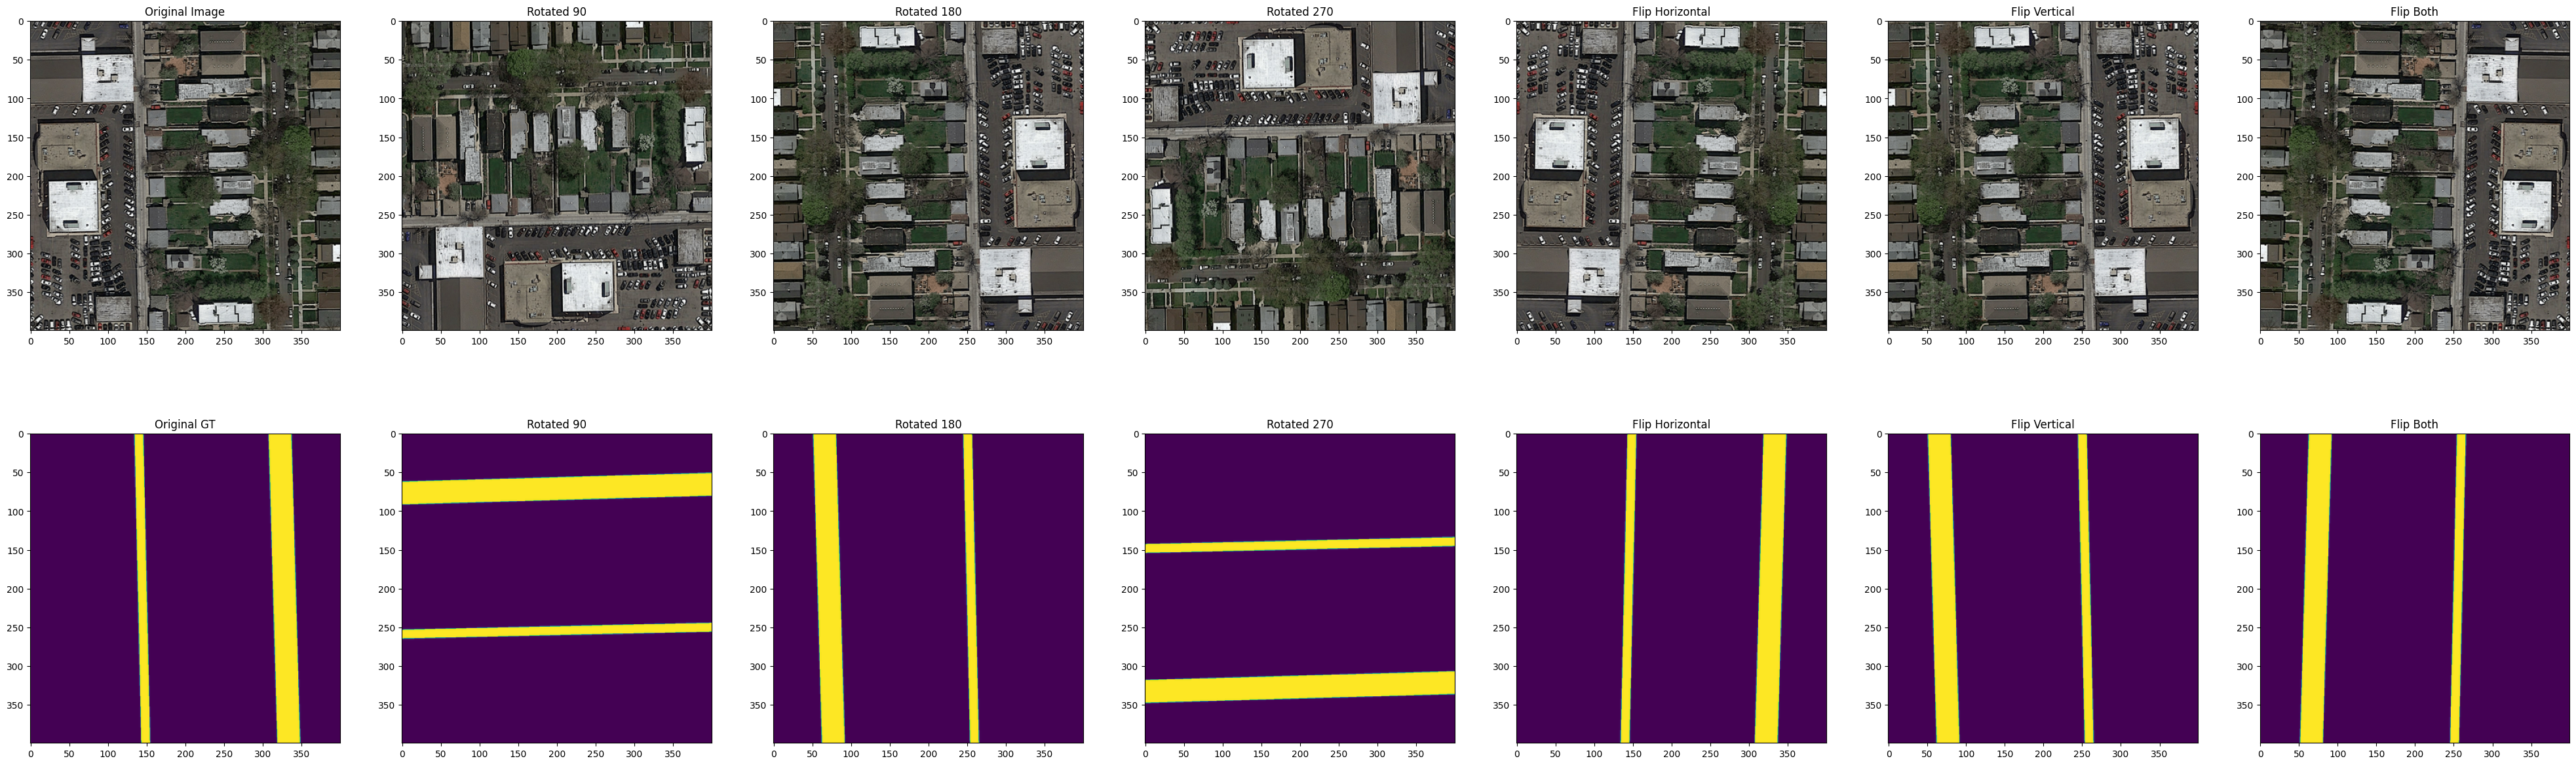

In [186]:
def visualize_augmented_data():
  rot90_images, rot90_gt = rot90(IMAGES_SRC, IMAGES_GT)
  rot180_images, rot180_gt = rot180(IMAGES_SRC, IMAGES_GT)
  rot270_images, rot270_gt = rot270(IMAGES_SRC, IMAGES_GT)
  fliph_images, fliph_gt = fliph(IMAGES_SRC, IMAGES_GT)
  flipv_images, flipv_gt = flipv(IMAGES_SRC, IMAGES_GT)
  flipvh_images, flipvh_gt = flipvh(IMAGES_SRC, IMAGES_GT)
  fig = plt.figure(figsize=(50, 15))
  fig.add_subplot(2, 7, 1)
  plt.imshow(IMAGES_SRC[0])
  plt.title("Original Image")
  fig.add_subplot(2, 7, 2)
  plt.imshow(rot90_images[0])
  plt.title("Rotated 90")
  fig.add_subplot(2, 7, 3)
  plt.imshow(rot180_images[0])
  plt.title("Rotated 180")
  fig.add_subplot(2, 7, 4)
  plt.imshow(rot270_images[0])
  plt.title("Rotated 270")
  fig.add_subplot(2, 7, 5)
  plt.imshow(fliph_images[0])
  plt.title("Flip Horizontal")
  fig.add_subplot(2, 7, 6)
  plt.imshow(flipv_images[0])
  plt.title("Flip Vertical")
  fig.add_subplot(2, 7, 7)
  plt.imshow(flipvh_images[0])
  plt.title("Flip Both")
  fig.add_subplot(2, 7, 8)
  plt.imshow(IMAGES_GT[0])
  plt.title("Original GT")
  fig.add_subplot(2, 7, 9)
  plt.imshow(rot90_gt[0])
  plt.title("Rotated 90")
  fig.add_subplot(2, 7, 10)
  plt.imshow(rot180_gt[0])
  plt.title("Rotated 180")
  fig.add_subplot(2, 7, 11)
  plt.imshow(rot270_gt[0])
  plt.title("Rotated 270")
  fig.add_subplot(2, 7, 12)
  plt.imshow(fliph_gt[0])
  plt.title("Flip Horizontal")
  fig.add_subplot(2, 7, 13)
  plt.imshow(flipv_gt[0])
  plt.title("Flip Vertical")
  fig.add_subplot(2, 7, 14)
  plt.imshow(flipvh_gt[0])
  plt.title("Flip Both")
  plt.show()

visualize_augmented_data()


In [187]:
augmented_src, augmented_gt = augment_data(IMAGES_SRC, IMAGES_GT)
print(augmented_src.shape)
print(augmented_gt.shape)

(600, 400, 400, 3)
(600, 400, 400)


## crop

In [188]:
PATCH_SIZE = 100
cropped_src, cropped_gt = np.asarray([img_crop(img, PATCH_SIZE, PATCH_SIZE) for img in augmented_src]).reshape((-1, PATCH_SIZE, PATCH_SIZE, 3)), np.asarray([img_crop(img, PATCH_SIZE, PATCH_SIZE) for img in augmented_gt]).reshape((-1, PATCH_SIZE, PATCH_SIZE))
print(cropped_src.shape)
print(cropped_gt.shape)

(9600, 100, 100, 3)
(9600, 100, 100)


# Dataset loading

In [189]:
ds_src, ds_gt = torch.stack([transforms.ToTensor()(i) for i in cropped_src]), torch.stack([transforms.ToTensor()(i) for i in cropped_gt]).squeeze()
print(ds_src.shape)
print(ds_gt.shape)

torch.Size([9600, 3, 100, 100])
torch.Size([9600, 100, 100])


In [190]:
dataset = TensorDataset(ds_src, ds_gt)

## + splitting

In [191]:
def split_dataset(dataset):
  train_size = int(len(dataset) * 0.9)
  test_size = len(dataset) - train_size
  return torch.utils.data.random_split(dataset, [train_size, test_size])

train_ds, test_ds = split_dataset(dataset)

# Model definition

In [192]:
class FCN(nn.Module):
    def __init__(self, refinement_layers=3):
        super(FCN, self).__init__()
        self.refinement_layers = refinement_layers

        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),

        )

        self.unconv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, stride=2, kernel_size=4, padding=1),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, stride=2, kernel_size=4, padding=1),
            nn.Sigmoid()
        )

        self.refinement_conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
        )

        self.refinement_conv2 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
        )

        self.refinement_conv3 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
        )

        self.refinement_conv4 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.1),
        )

        self.refinement_unconv1 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, stride=2, kernel_size=4, padding=1),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, stride=2, kernel_size=4, padding=1),
            nn.Sigmoid()
        )

        self.refinement_unconv2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, stride=2, kernel_size=4, padding=1),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, stride=2, kernel_size=4, padding=1),
            nn.Sigmoid()
        )

        self.refinement_unconv3 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, stride=2, kernel_size=4, padding=1),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, stride=2, kernel_size=4, padding=1),
            nn.Sigmoid()
        )

        self.refinement_unconv4 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, stride=2, kernel_size=4, padding=1),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 1, stride=2, kernel_size=4, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.unconv(x)
        x = self.refinement_conv1(x)
        x = self.refinement_unconv1(x)
        x = self.refinement_conv2(x)
        x = self.refinement_unconv2(x)
        x = self.refinement_conv3(x)
        x = self.refinement_unconv3(x)
        x = self.refinement_conv4(x)
        x = self.refinement_unconv4(x)
        return x.squeeze()
    
summary(FCN(), input_size=(6, 3, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
FCN                                      [6, 100, 100]             --
├─Sequential: 1-1                        [6, 32, 25, 25]           --
│    └─Conv2d: 2-1                       [6, 16, 100, 100]         1,216
│    └─BatchNorm2d: 2-2                  [6, 16, 100, 100]         32
│    └─MaxPool2d: 2-3                    [6, 16, 50, 50]           --
│    └─LeakyReLU: 2-4                    [6, 16, 50, 50]           --
│    └─Conv2d: 2-5                       [6, 32, 50, 50]           12,832
│    └─BatchNorm2d: 2-6                  [6, 32, 50, 50]           64
│    └─MaxPool2d: 2-7                    [6, 32, 25, 25]           --
│    └─LeakyReLU: 2-8                    [6, 32, 25, 25]           --
├─Sequential: 1-2                        [6, 1, 100, 100]          --
│    └─ConvTranspose2d: 2-9              [6, 16, 50, 50]           8,208
│    └─LeakyReLU: 2-10                   [6, 16, 50, 50]           --
│    

# Training!

In [193]:
def train_epoch(model, device, train_loader, optimizer, epoch, criterion):
    model.train()

    loss_history = []
    acc_history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        output = output > 0.5
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        acc_history.append((output.eq(target).sum() / target.numel()).item())

    return acc_history, loss_history

In [194]:
def train(device, epochs = 60):
    pytorchDl = DataLoader(train_ds,batch_size = 32,shuffle=True)
    model = FCN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.functional.binary_cross_entropy

    for i in range(epochs):
        acc_history, loss_history = train_epoch(model, device, pytorchDl, optimizer, i, criterion)
        print("Epoch: ", i, " Accuracy: ", sum(acc_history)/len(acc_history), " Loss: ", sum(loss_history)/len(loss_history))

    return model

# Let's play!

In [195]:
model = train(device, 50)

Epoch:  0  Accuracy:  0.7263967059828617  Loss:  0.3650515255000856
Epoch:  1  Accuracy:  0.7282123782016613  Loss:  0.3104896703803981
Epoch:  2  Accuracy:  0.7366189512941572  Loss:  0.29145320825002813
Epoch:  3  Accuracy:  0.7414636962943607  Loss:  0.26596108106551347
Epoch:  4  Accuracy:  0.7452365435935833  Loss:  0.247285025815169
Epoch:  5  Accuracy:  0.7488234065197132  Loss:  0.2325514068758046
Epoch:  6  Accuracy:  0.7508365299966601  Loss:  0.22168333497312334
Epoch:  7  Accuracy:  0.753013939106906  Loss:  0.21175262370595224
Epoch:  8  Accuracy:  0.7540578398439619  Loss:  0.20244282186031343
Epoch:  9  Accuracy:  0.7548134759620384  Loss:  0.20003775338883753
Epoch:  10  Accuracy:  0.7555885933063649  Loss:  0.19285869741881334
Epoch:  11  Accuracy:  0.7565655366138175  Loss:  0.18796692283617125
Epoch:  12  Accuracy:  0.7575006405512492  Loss:  0.18155900551765053
Epoch:  13  Accuracy:  0.7572203397750854  Loss:  0.1816020896313367
Epoch:  14  Accuracy:  0.757554276342

# Visualize results?

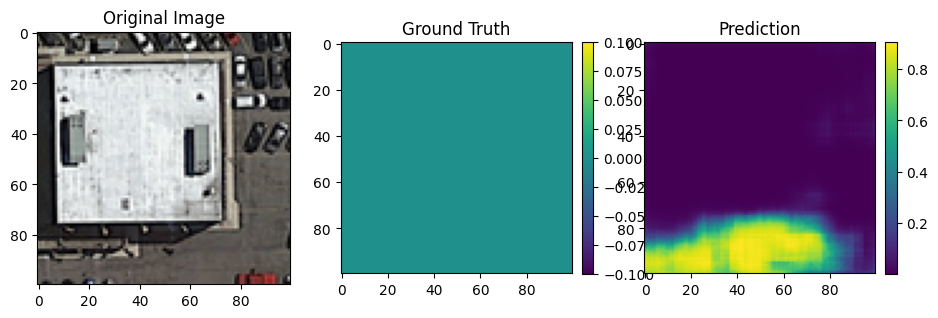

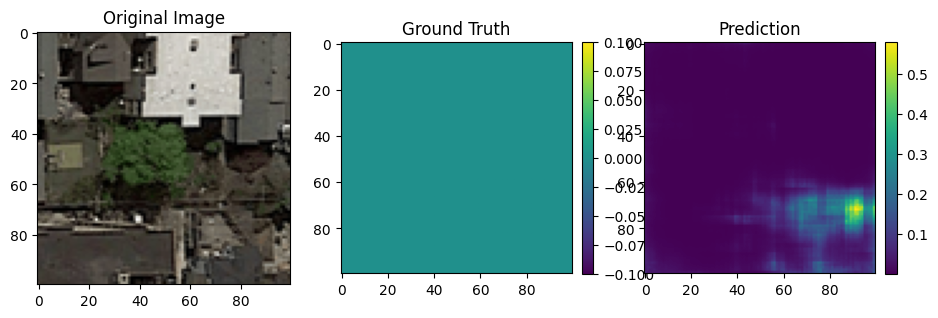

In [196]:
def visualize_result(device, model, dataset):
  model.eval()
  pytorchDl = DataLoader(dataset,batch_size = 1,shuffle=True)
  for data, target in pytorchDl:
    data = data.squeeze()
    target = target.squeeze()
    output = model.forward(data.to(device).unsqueeze(0))
    data, target = data.cpu().numpy().transpose((1, 2, 0)), target.cpu().numpy()

    fig = plt.figure(figsize=(15, 15))
    fig.add_subplot(1, 4, 1)
    im = plt.imshow(data)
    plt.title("Original Image")
    fig.add_subplot(1, 4, 2)
    im = plt.imshow(target)
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Ground Truth")
    fig.add_subplot(1, 4, 3)
    im = plt.imshow(output.cpu().detach().numpy())
    fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Prediction")
    plt.show()
    break

visualize_result(device, model, train_ds)
visualize_result(device, model, test_ds)



# Making a submission